# DRV5056 + KS-20 Magnet Distance Notes

This notebook contains my notes on creating a lookup table for mapping DRV5056 ADC readings to the KS-20 magnet distance.

The formula used for generating the magnetic formula is as follows:

![Magnet Dimensions](./magnet-distance/magnet-dimensions.png)

![Magnetic Flux Formula](./magnet-distance/magnetic-flux-formula.png)

The Gateron KS-20 has the following magnet specifications:

- Cylindrical Permanent Magnet
  - Thickness: 3.5mm
  - Diameter: 2.8mm
- PCB Thickness: 1.6mm
- Distance from Bottom of Chip: [1.9mm, 5.9mm]
  - Initial Position: 0.3mm from top of switch
- Magnetic Flux at North Pole:
  - Initial Position: 102 +/- 15G
  - Total Travel Position: 905 +/- 80G

In [43]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [44]:
def cylindrical_magnetic_profile(b_r: float, t: float, r: float, dists):
    """ Function to calculate the magnetic profile for a cylindrical magnet. """
    half_b_r = b_r / 2.0
    r_squared = r * r

    # Left Fraction
    lf_numerator = dists + t
    lf_denominator = np.sqrt(r_squared + ((dists + t) ** 2))
    lf = lf_numerator / lf_denominator

    # Right Fraction
    rf_denominator = np.sqrt(r_squared + (dists ** 2))
    rf = dists / rf_denominator

    return half_b_r * (lf - rf)

def drv5056_voltage(profile, quiescent, sensitivity, temperature):
    """ Converts the magnetic profile to expected readings on a DRV5056. """
    return quiescent + profile * (sensitivity * (1.0 + 0.0012 * (temperature - 25.0)))

def adc_value(voltage: float, v_ref: float, adc_bits: int):
    """ Gets the ADC value for a particular voltage. """
    max_adc = (2 ** adc_bits) - 1
    return max_adc * (voltage / v_ref)

def adc_values(voltages, v_ref: float, adc_bits: int):
    """ Converts voltage readings into ADC values. """
    max_adc = (2 ** adc_bits) - 1
    return max_adc * (voltages / v_ref)


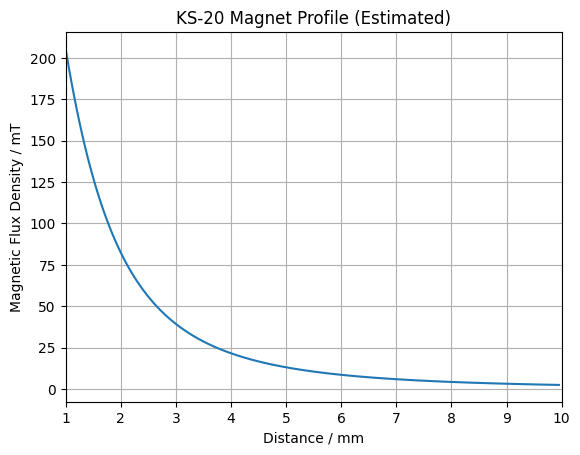

In [45]:
# KS-20 Magnetic Profile Parameters
# The remanence used is probably incorrect, as the magnet dimensions aren't specified
# However, this still closely matches the magnetic flux density at the positions in the datasheet
b_r = 1100          # mT
t = 3.5             # mm
r = 2.8 / 2.0       # mm
min_dist = 1.0      # mm
max_dist = 10.0     # mm
step = 0.05         # mm

dists = np.arange(min_dist, max_dist, step)
profile = cylindrical_magnetic_profile(b_r, t, r, dists)

plt.grid()
plt.xlim(min_dist, max_dist)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(dists, profile)
plt.title('KS-20 Magnet Profile (Estimated)')
plt.show()

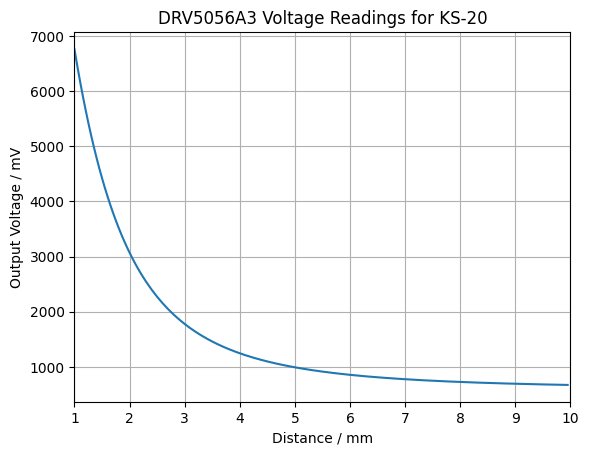

In [46]:
# Voltage Readings for DRV5056A3
quiescent = 600.0       # mV
sensitivity_a3 = 30.0   # mV
temperature = 25.0      # oC

voltages_a3 = drv5056_voltage(profile, quiescent, sensitivity_a3, temperature)

plt.grid()
plt.xlim(min_dist, max_dist)
plt.xlabel('Distance / mm')
plt.ylabel('Output Voltage / mV')
plt.plot(dists, voltages_a3)
plt.title('DRV5056A3 Voltage Readings for KS-20')
plt.show()

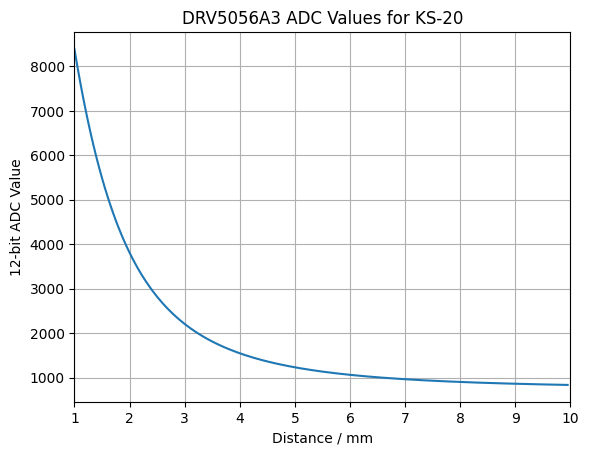

In [47]:
# ADC Values for DRV5056A3
v_ref = 3300.0  # mV
adc_bits = 12

adc_a3 = adc_values(voltages_a3, v_ref, adc_bits)

plt.grid()
plt.xlim(min_dist, max_dist)
plt.xlabel('Distance / mm')
plt.ylabel('12-bit ADC Value')
plt.plot(dists, adc_a3)
plt.title('DRV5056A3 ADC Values for KS-20')
plt.show()

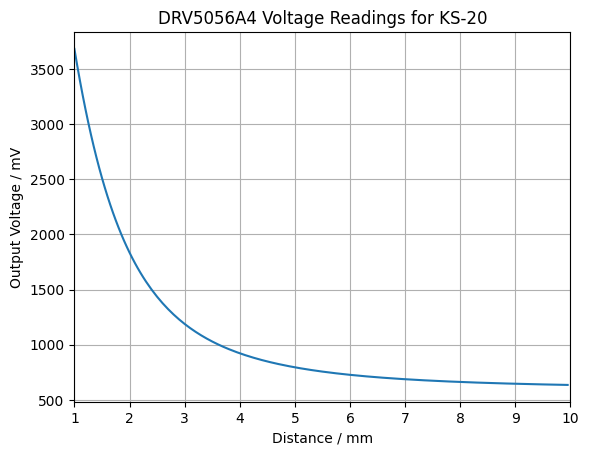

In [48]:
# Voltage Readings for DRV5056A4
quiescent = 600.0       # mV
sensitivity_a4 = 15.0   # mV
temperature = 25.0      # oC

voltages_a4 = drv5056_voltage(profile, quiescent, sensitivity_a4, temperature)

plt.grid()
plt.xlim(min_dist, max_dist)
plt.xlabel('Distance / mm')
plt.ylabel('Output Voltage / mV')
plt.plot(dists, voltages_a4)
plt.title('DRV5056A4 Voltage Readings for KS-20')
plt.show()

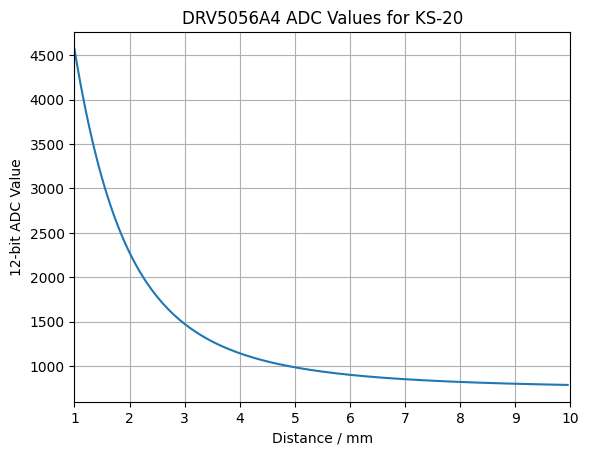

In [49]:
# ADC Values for DRV5056A4
v_ref = 3300.0  # mV
adc_bits = 12

adc_a4 = adc_values(voltages_a4, v_ref, adc_bits)

plt.grid()
plt.xlim(min_dist, max_dist)
plt.xlabel('Distance / mm')
plt.ylabel('12-bit ADC Value')
plt.plot(dists, adc_a4)
plt.title('DRV5056A4 ADC Values for KS-20')
plt.show()

## Reference Graphs for Curve Fitting

In [50]:
quiescent_adc = adc_value(600.0, 3300.0, 12)
max_adc = 4095.0
adc_step = 1.0

adc_range = np.arange(quiescent_adc, max_adc, adc_step)

print('Quiescent ADC:', quiescent_adc)

Quiescent ADC: 744.5454545454546


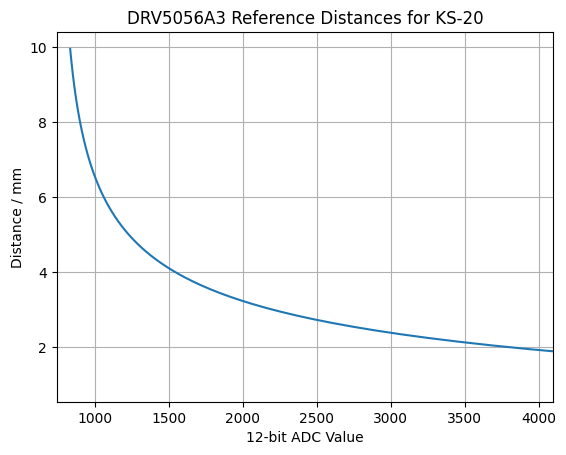

In [51]:
# DRV5056A3 Reference Graph
plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(adc_a3, dists)
plt.title('DRV5056A3 Reference Distances for KS-20')
plt.show()

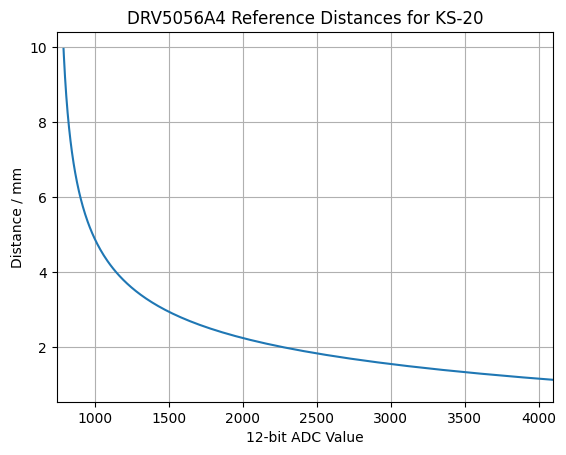

In [52]:
# DRV5056A4 Reference Graph
plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(adc_a4, dists)
plt.title('DRV5056A4 Reference Distances for KS-20')
plt.show()

## Attempt 1 - Exponential Curve Fit

The curve shape mostly matches that of an exponential graph (`ae^(-bx) + c`), so we can try to find the appropriate parameters.

The resulting graph is mostly OK, but it's unable to measure anything below 2.0mm, so a different curve fit is needed.

In [53]:
def drv5056_exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

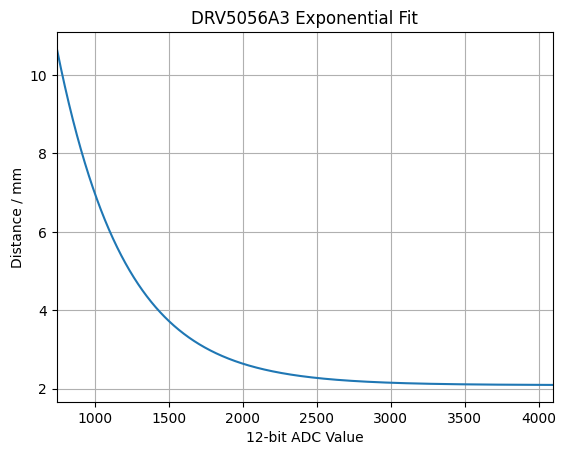

In [54]:
# DRV5056A3 Exponential Curve Fitting
popt_a3, pcov_a3 = curve_fit(drv5056_exponential, adc_a3, dists, p0=(1, 0.0001, 1))
exp_fit_a3 = drv5056_exponential(adc_range, *popt_a3)

plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.title('DRV5056A3 Exponential Fit')
plt.plot(adc_range, exp_fit_a3)

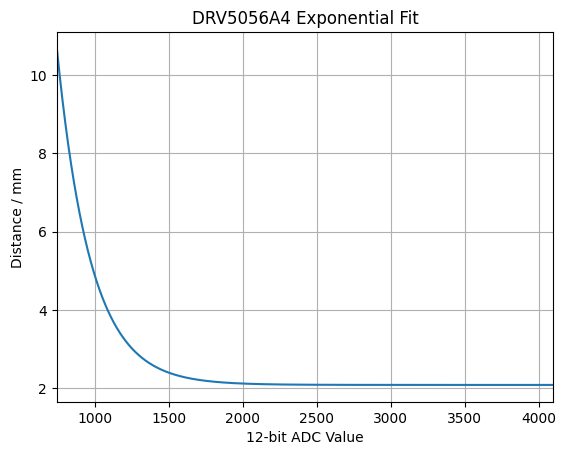

In [55]:
# DRV5056A4 Exponential Curve Fitting
popt_a4, pcov_a4 = curve_fit(drv5056_exponential, adc_a4, dists, p0=(1, 0.0001, 1))
exp_fit_a4 = drv5056_exponential(adc_range, *popt_a4)

plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.title('DRV5056A4 Exponential Fit')
plt.plot(adc_range, exp_fit_a4)

## Attempt 2 - Reciprocal Graph Fit

The curve also matches the shape of a reciprocal graph (`a/(x-b) + c`), though some extra care is needed around the asymptotes.

Both curves are a better fit than the exponential graph, with the DRV5056A4 having a more accurate profile due to it's increased magnetic range. The DRV5056A3 is still usable though.

In [56]:
def drv5056_fractional(x, a, b, c):
    return (a / (x - b)) + c

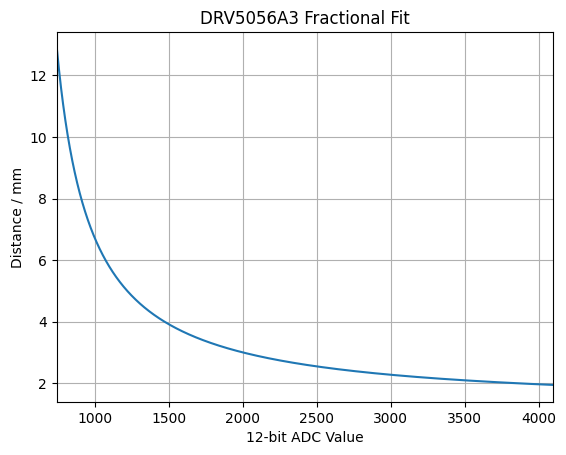

In [57]:
# DRV5056A3 Fractional Curve Fitting
popt_a3, pcov_a3 = curve_fit(drv5056_fractional, adc_a3, dists, p0=(2.0, quiescent_adc, 1.9))
exp_fit_a3 = drv5056_fractional(adc_range, *popt_a3)

plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.title('DRV5056A3 Fractional Fit')
plt.plot(adc_range, exp_fit_a3)

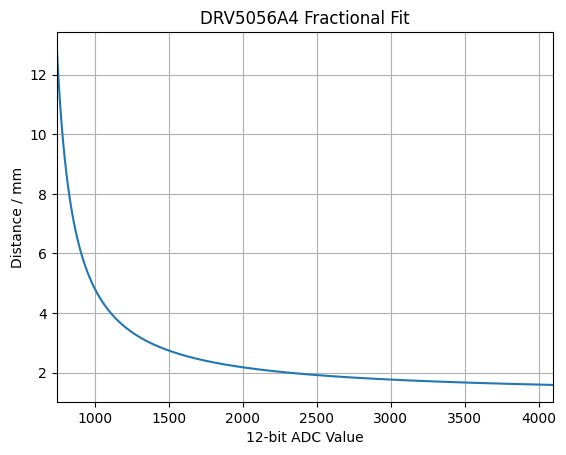

In [58]:
# DRV5056A4 Fractional Curve Fitting
popt_a4, pcov_a4 = curve_fit(drv5056_fractional, adc_a4, dists, p0=(2.0, quiescent_adc, 1.9))
exp_fit_a4 = drv5056_fractional(adc_range, *popt_a4)

plt.grid()
plt.xlim(quiescent_adc, max_adc)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.title('DRV5056A4 Fractional Fit')
plt.plot(adc_range, exp_fit_a4)